In [2]:
import torch
import pandas as pd
import numpy as np
from torch_geometric.datasets import QM9
from pathlib import Path
from tqdm import tqdm
import time

#### Data Loading 

In [3]:
print("Loading QM9 dataset...")
dataset = QM9(root='data/QM9')  # Downloads automatically first time
print(f"Loaded {len(dataset)} molecules")

Loading QM9 dataset...
Loaded 130831 molecules


In [4]:
print(dataset[99])  # Print the first molecule's data structure

Data(x=[13, 11], edge_index=[2, 26], edge_attr=[26, 4], y=[1, 19], pos=[13, 3], idx=[1], name='gdb_103', z=[13])


#### Extract properties

In [5]:
# Official names in order of indices 0-18
property_names = [
    'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 
    'u298', 'h298', 'g298', 'cv', 'u0_atom', 'u298_atom', 
    'h298_atom', 'g298_atom', 'A', 'B', 'C'
]

def rename_properties(data):
    # Create a dictionary mapping name -> value from the y tensor
    data.properties = {name: data.y[0, i].item() for i, name in enumerate(property_names)}
    return data

# Example: Accessing the first molecule
mol_data = rename_properties(dataset[0])

print(f"Dipole Moment (mu): {mol_data.properties['mu']}")
print(f"HOMO-LUMO Gap: {mol_data.properties['gap']}")

Dipole Moment (mu): 0.0
HOMO-LUMO Gap: 13.736308097839355


#### converting to a Pandas DataFrame

In [6]:
import pandas as pd

# Convert all targets to a DataFrame
y_values = dataset.data.y.numpy()
df = pd.DataFrame(y_values, columns=property_names)

# View the first 5 molecules with their named properties
print(df.head())

       mu      alpha       homo      lumo        gap         r2      zpve  \
0  0.0000  13.210000 -10.549854  3.186453  13.736308  35.364101  1.217682   
1  1.6256   9.460000  -6.993326  2.255824   9.249149  26.156300  0.934929   
2  1.8511   6.310000  -7.967494  1.869422   9.836916  19.000200  0.581643   
3  0.0000  16.280001  -7.741639  1.376896   9.118535  59.524799  0.730381   
4  2.8937  12.990000  -9.806983  0.519737  10.329442  48.747601  0.451736   

            u0         u298         h298         g298     cv    u0_atom  \
0 -1101.487793 -1101.409790 -1101.384033 -1102.022949  6.469 -17.172182   
1 -1538.147705 -1538.069824 -1538.044189 -1538.666748  6.316 -12.005855   
2 -2079.077881 -2079.000732 -2078.975098 -2079.558105  6.002  -9.240362   
3 -2103.669434 -2103.590576 -2103.564697 -2104.186523  8.574 -16.716963   
4 -2541.866943 -2541.798340 -2541.772705 -2542.393555  6.278 -13.088188   

   u298_atom  h298_atom  g298_atom           A           B           C  
0 -17.286823 

C:\Users\VilitaDsouza\AppData\Local\Temp\ipykernel_7520\1870434313.py:4: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  y_values = dataset.data.y.numpy()


#### Basic validation

In [7]:
print("\nBASIC VALIDATION")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print("\n Missing values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "None")

print("\n Property ranges:")
for col in ['mu', 'alpha', 'homo', 'lumo', 'gap']:
    rng = df[col].agg(['min', 'max']).round(3)
    print(f"  {col}: {rng['min']} → {rng['max']}")


BASIC VALIDATION
Shape: (130831, 19)
Columns: ['mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u298', 'h298', 'g298', 'cv', 'u0_atom', 'u298_atom', 'h298_atom', 'g298_atom', 'A', 'B', 'C']

 Missing values:
None

 Property ranges:
  mu: 0.0 → 29.555999755859375
  alpha: 6.309999942779541 → 196.6199951171875
  homo: -11.663000106811523 → -2.7669999599456787
  lumo: -4.76200008392334 → 5.264999866485596
  gap: 0.6690000295639038 → 16.92799949645996


## Data Cleaning Steps

In [8]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# DEFINE num_cols HERE (this was missing!)
num_cols = ['mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 
            'u298', 'h298', 'g298', 'cv', 'u0_atom', 'u298_atom', 
            'h298_atom', 'g298_atom', 'A', 'B', 'C']

def clean_qm9_data(df):
    df_clean = df.copy()
    
    # Remove exact duplicates
    initial_rows = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    print(f"Removed {initial_rows - len(df_clean)} duplicates")
    
    # Handle outliers (99th percentile)
    outlier_cols = ['mu', 'alpha', 'gap', 'zpve', 'u0']
    for col in outlier_cols:
        Q1 = df_clean[col].quantile(0.01)
        Q3 = df_clean[col].quantile(0.99)
        df_clean = df_clean[(df_clean[col] >= Q1) & (df_clean[col] <= Q3)]
    
    print(f"After outlier removal: {len(df_clean)} rows")
    
    # Normalize key properties
    scaler = StandardScaler()
    key_props = ['mu', 'alpha', 'homo', 'lumo', 'gap', 'zpve', 'u0']
    df_clean[key_props] = scaler.fit_transform(df_clean[key_props])
    
    return df_clean, scaler

# 2. Execute cleaning
df_clean, scaler = clean_qm9_data(df)

Removed 28 duplicates
After outlier removal: 118242 rows


####  Statistical Analysis

In [9]:
stats = df_clean[num_cols].describe().round(3)
corr_matrix = df_clean[num_cols].corr()

#### Save Deliverables

In [10]:
Path("deliverables").mkdir(exist_ok=True)
df_clean.to_csv('deliverables/qm9_clean_properties.csv', index=False)
stats.to_csv('deliverables/clean_stats.csv')
corr_matrix.to_csv('deliverables/correlation_matrix.csv')

#### Quick correlation plot

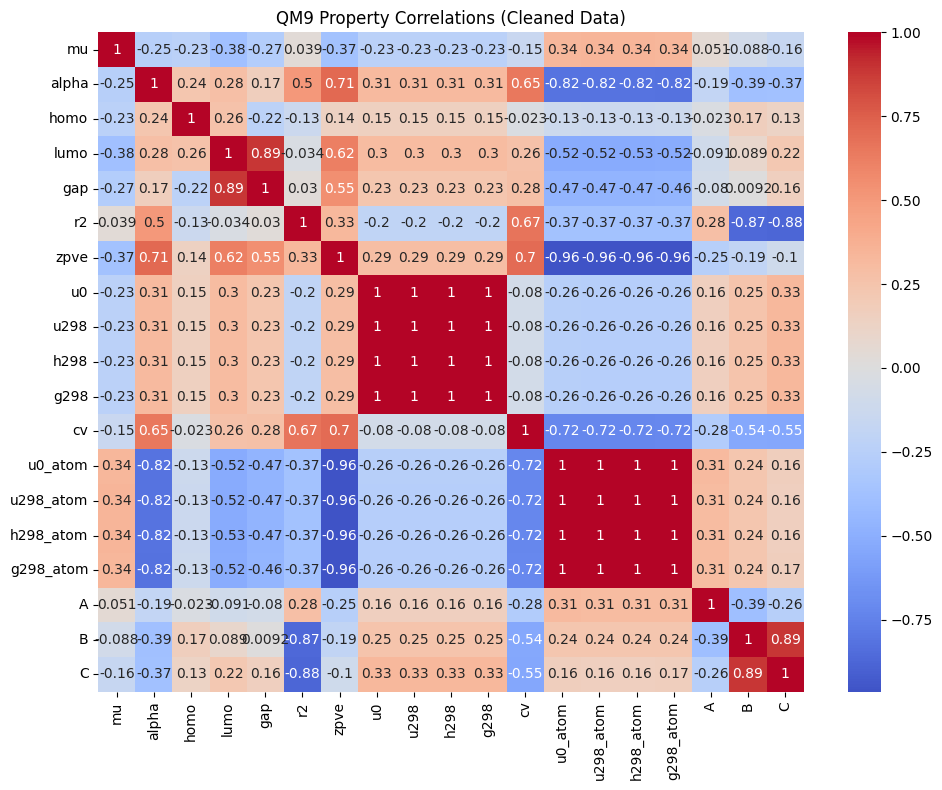

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('QM9 Property Correlations (Cleaned Data)')
plt.tight_layout()
plt.savefig('deliverables/correlations.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
print(f"Loaded: {df.shape}")
print(f"Clean data: {df_clean.shape}")

Loaded: (130831, 19)
Clean data: (118242, 19)
